Using GEDI, and Sentinel Imagery to investigate mangrove heights in Myanmar.

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from rasterio.plot import show
import numpy as np
import pandas as pd
import rasterio


In [1]:
file = '1764_GEDI_2021.shp'
GEDI_data = gpd.read_file(file)

im_data = 'S2_1764_2021_allbands.tiff'

with rio.open(im_data) as src:
    img_data = src.read()

img_val = []
for i in range(len(GEDI_data)):
    row, col = src.index(GEDI_data.geometry[i].x, GEDI_data.geometry[i].y)
    img_val.append(img_data[:, row, col])
ht_data = pd.concat([GEDI_data, pd.DataFrame(img_val)], axis=1)
htData = ht_data.drop(ht_data.columns[-2:], axis=1)

htData = htData[['rh98'] + list(htData.columns[5:])]

mean_y = np.mean(htData.iloc[:, 0])
sd_y = np.std(htData.iloc[:, 0])

threshold = 0.5 * sd_y

anomalous_indices = np.where(abs(htData.iloc[:, 0] - mean_y) > threshold)

clean_frac = htData.drop(anomalous_indices[0], axis=0)
frac = np.random.rand(len(clean_frac)) < 0.65

training = clean_frac[frac]
testing = clean_frac[~frac]

X_train = training.iloc[:, 1:]
y_train = training.iloc[:, 0]
X_test = testing.iloc[:, 1:]
y_test = testing.iloc[:, 0]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

/var/folders/25/04tzn1gd7lj5p2nfj2mffb040000gn/T/ipykernel_27114/1499239727.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


Fitting a model to the data

/Users/yayayapoop/opt/anaconda3/envs/geopython/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yayayapoop/opt/anaconda3/envs/geopython/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yayayapoop/opt/anaconda3/envs/geopython/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly s

<Axes: xlabel='Feature'>

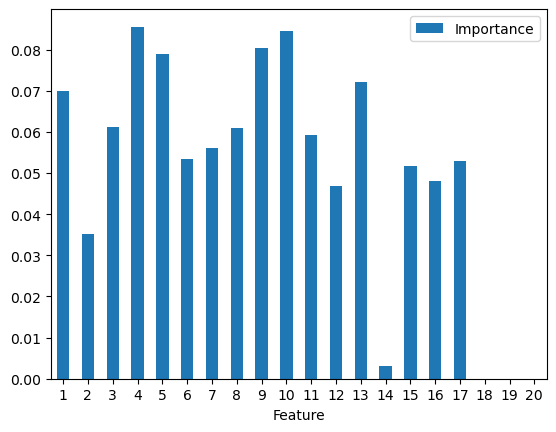

In [5]:

fitControl = KFold(n_splits=5, shuffle=True, random_state=1)
rfGrid = {'n_estimators': [10, 50, 100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']}
rfFit1 = GridSearchCV(RandomForestRegressor(random_state=1), param_grid=rfGrid, cv=fitControl, verbose=False, n_jobs=-1)
rfFit1.fit(training.iloc[:, 1:], training.iloc[:, 0])
# print(rfFit1.best_estimator_)
rfImp = pd.DataFrame({'Feature': training.iloc[:, 1:].columns, 'Importance': rfFit1.best_estimator_.feature_importances_})
rfImp.plot.bar(x='Feature', y='Importance', rot=0)

In [19]:

test = testing.iloc[:, 1:]
predictedHt = rfFit1.predict(test)
result = np.polyfit(predictedHt, testing.iloc[:, 0], 1, full=True)
print(result[0])
print(mean_squared_error(testing.iloc[:, 0], predictedHt, squared=False))
nRMSE = np.sqrt(np.mean((predictedHt - testing.iloc[:, 0])**2)) / (max(testing.iloc[:, 0]) - min(testing.iloc[:, 0]))
print(nRMSE)



[ 1.73898005 -2.57771819]
0.6244354864429211
0.23213214615621308


In [16]:
predictedHt

array([3.57150004, 3.87949997, 3.46550002, 3.53460001, 3.99969999,
       3.523     , 4.31489994, 3.65310001, 4.09889995, 3.69639999,
       3.50800001, 3.39410004, 3.70840002, 3.74550003, 3.61899999,
       3.69119999, 3.6582    , 3.60140004, 3.64050001, 3.48680002,
       4.05819998, 4.0252    , 3.87770002, 3.89759998, 3.45990003,
       3.48810004, 3.51310004, 3.5781    , 3.47029997, 3.66329997,
       3.5631    , 3.39610003, 3.72950002, 3.29370003, 3.79109996,
       3.48650004, 3.372     , 3.31400002, 3.67499997, 3.49250002,
       3.4275    , 3.9408    , 3.78819993, 3.39220004, 3.48890002,
       3.884     , 3.73540002, 3.99359999, 3.75899998, 3.3177    ,
       3.44530001, 3.7471    , 3.33250005, 3.56980001, 3.62789998,
       3.48690005, 3.77610001, 3.3938    ])

In [25]:
type(predictedHt)

numpy.ndarray

In [26]:
aa = testing.iloc[:, 0]
aa_np = aa.to_numpy()

Plotting the predicted and the actual heights from the GEDI model 

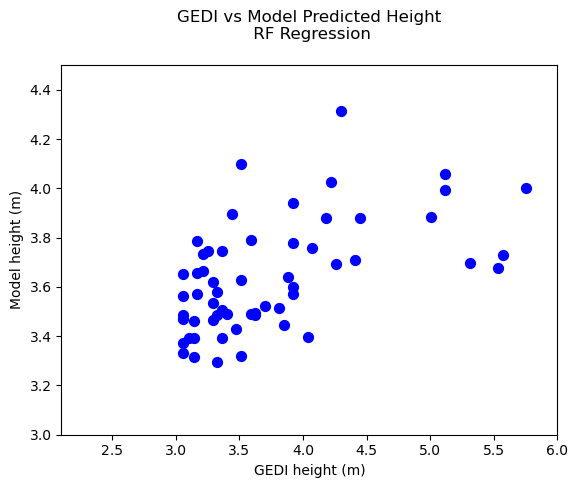

In [30]:
import matplotlib.pyplot as plt

plt.scatter(aa_np, predictedHt, marker='o', s=50, c='blue')
# plt.plot([0,13], [0,13], 'r--')
plt.title("GEDI vs Model Predicted Height\n RF Regression\n")
plt.xlabel("GEDI height (m)")
plt.ylabel("Model height (m)")
plt.xlim(2.1,6)
plt.ylim(3,4.5)
plt.show()